In [1]:
# Math and Dataframes
import numpy as np
from numpy import save
from numpy import savetxt
from numpy import loadtxt
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
from scipy.stats import norm

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
import h5py
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle

In [2]:
from draft import Regression_Hertz, Hertz_Dataset, error_fn, plot_error_hist, plot_bad_curves, plot_pred_real_curves, tensor_input_shape, hertz

In [3]:
parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface'
# parent_dir = os.getcwd()
os.chdir(parent_dir)

In [4]:
# Define min r2
min_r2 = 0.9
# min_r2 = 0.95

# Read pickle file
os.chdir(os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir), 'afm_stiffness_estimator'))
if min_r2 == 0.95:
    df=pd.read_pickle("exp_test_hertz_95.pkl")
elif min_r2 == 0.97:
    df=pd.read_pickle("exp_test_hertz_97.pkl")
elif min_r2 == 0.99:
    df=pd.read_pickle("exp_test_hertz_99.pkl")
elif min_r2 == 0.9:
    df=pd.read_pickle("exp_test_hertz_90.pkl")
os.chdir(parent_dir)
# df.head()

# Create new df and drop unnecessary columns

df_exp = df.drop(['index', 'fhertz', 'r2hertz'], axis=1, inplace=False)

df_exp.reset_index(inplace=True)
df_exp.drop(['index'], axis=1, inplace=True)

# df_exp.tail()
len(df_exp)

41634

(array([8.5000e+02, 5.9110e+03, 1.1444e+04, 1.1241e+04, 7.3940e+03,
        3.6330e+03, 9.7900e+02, 1.5000e+02, 2.6000e+01, 6.0000e+00]),
 array([ 48.27605952,  83.19040182, 118.10474411, 153.01908641,
        187.93342871, 222.847771  , 257.7621133 , 292.67645559,
        327.59079789, 362.50514019, 397.41948248]),
 <BarContainer object of 10 artists>)

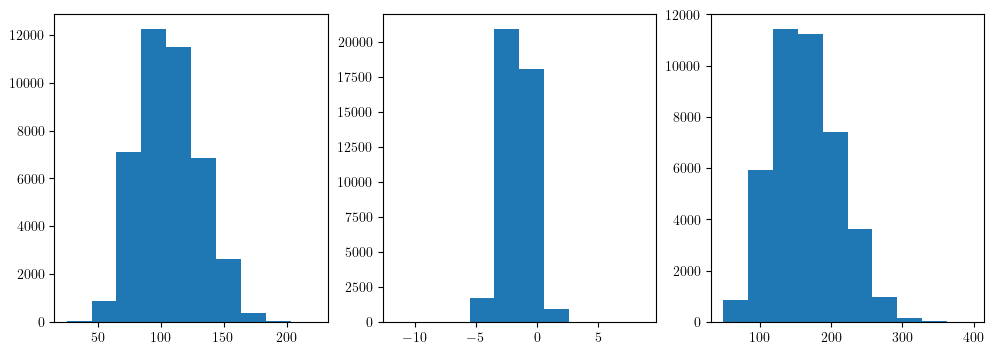

In [5]:
# Auxiliary lists to study the range of indentation in selected curves
# Ind_approach_contact with length n corresponds to the last n elements of ind_approach
npts, min_ind_list, max_ind_list = [], [], []
for i in range(len(df_exp)):
    ind_complete = df_exp['ind_approach'][i]
    ind_contact = df_exp['ind_approach_contact'][i]
    # print(len(ind_contact), min(ind_contact), max(ind_contact))
    npts.append(len(ind_contact))
    min_ind_list.append(min(ind_contact))
    max_ind_list.append(max(ind_contact))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))
ax1.hist(npts)
ax2.hist(min_ind_list)
ax3.hist(max_ind_list)


In [6]:
def rem_neg(main_list:list, aux_list: list):
    # Removes negative values from force and indentation vectors
    aux_arr = np.array([main_list, aux_list])
    neg_ind_arr = np.where(aux_arr<0)[1]
    if len(neg_ind_arr) > 0:
        last_neg_ind = neg_ind_arr.max()
        return main_list[last_neg_ind+1:]
    else:
        return main_list
    
def rem_greater(target_ind:int, ind_list:list, force_list: list, return_ind: bool):
    # remove points with indentation greater than max indentation value used for training
    aux_arr = np.array(ind_list)
    idx = np.argwhere(aux_arr < target_ind)[-1].item()
    if return_ind:
        return ind_list[:idx+1]
    else:
        return force_list[:idx+1]
    
def interp_last(target_ind: int, ind_list:list, force_list: list, return_ind: bool):
    # ensures last point corresponds exactly to the training max ind
    if return_ind:
        ind_list[-1] = target_ind
        return ind_list
    else:
        f_interp = np.interp(target_ind, ind_list, force_list)
        force_list[-1] = f_interp
        return force_list
    
    
def adjust_npts(target_npts: int, current_list: list):
    # Adjusts the length of the vector, according to the length of training vectors
    n = len(current_list)
    diff = n-target_npts
    spacing = target_npts/(diff+1)
    for i in range(diff):
        current_list.pop(round((i)*spacing)) # using 'i' the 1st pt is always removed but never the last pt, using 'i+1' the last pt may be removed
    return current_list

# Convert variable name to string
def varname(var):
    return [tpl[0] for tpl in filter(lambda x: var is x[1], globals().items())][0]

def create_npy(data: list): # [X, Y, Z, E_map, idx_map, x_map, E_pred, error_mat]
    a_dir = os.getcwd()
    dir_name = 'npy_files'
    os.mkdir(dir_name)
    os.chdir(dir_name)
    for var in data:
        file_name = varname(var) + '.npy'
        save(file_name, var)
    os.chdir(a_dir)

def plot_Emap(X, Y, Z, E_real, E_predict, Emin, Emax):
    mat_list = [E_real, E_predict]
    for i, mat in enumerate(mat_list):
        fig=plt.figure(figsize=(12, 5), dpi=120, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111, projection='3d')
        # Plot the 3D surface
        ls = LightSource(270, 45)
        rgb = ls.shade(mat, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                            linewidth=0, antialiased=False, shade=False)
        # Set the aspect ratio for the axes
        ax.set_box_aspect([1,1,0.5])
        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z', labelpad=-10)
        # Remove ticks from the axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        # Add a color bar with ticks and labels
        if i == 1:
            mappable = plt.cm.ScalarMappable(cmap=cm.gist_earth)
            mappable.set_array(mat)
            mappable.set_clim(Emin, Emax)
            cbar = fig.colorbar(mappable, shrink=0.6, aspect=10)
            cbar.ax.set_title('E (KPa)', pad=15)
        #grid off
        ax.grid(False)
        # Show the plot
        plt.tight_layout()
        if i == 0:
            ax.set_title('Real E map', fontsize=24)
            plt.savefig('E_real_map.pdf', bbox_inches='tight')
        else:
            ax.set_title('Predicted E map', fontsize=24)
            plt.savefig('E_predict_map.pdf', bbox_inches='tight')

def plot_error_map(X, Y, Z, error_mat):
    fig=plt.figure(figsize=(12, 5), dpi= 120, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')
    # Plot the 3D surface
    ls = LightSource(270, 45)
    rgb = ls.shade(error_mat, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False)
    # Set the aspect ratio for the axes
    ax.set_box_aspect([1,1,0.5])
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z', labelpad=-10)
    # Remove ticks from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Add a color bar with ticks and labels
    mappable = plt.cm.ScalarMappable(cmap=cm.gist_earth)
    mappable.set_array(error_mat)
    cbar = fig.colorbar(mappable, shrink=0.6, aspect=10)
    cbar.ax.set_title('Error (\%)', pad=15)
    #grid off
    ax.grid(False)
    # Show the plot
    plt.tight_layout()
    plt.savefig('error_map.pdf', bbox_inches='tight')

# Define a function to get the coordinates of minimum and maximum error values
def get_min_max_error(error_map):
    min_error = np.min(error_map)
    max_error = np.max(error_map)
    min_error_idx = np.where(error_map == min_error)
    max_error_idx = np.where(error_map == max_error)
    # coordinates of value that is closest to 10% error
    diff = abs(error_map - 10)
    min_diff = np.min(diff)
    min_diff_idx = np.where(diff == min_diff)
    return min_error_idx, max_error_idx, min_diff_idx

def plot_map(X, Y, Z, error_map, X_full, Y_full, Z_full):
    fig=plt.figure(figsize=(12, 5), dpi= 120, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')
    # Plot the 3D surface
    ls = LightSource(270, 45)
    rgb = ls.shade(Z_full, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X_full, Y_full, Z_full, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False, alpha=0.2)
    min, max, e10 = get_min_max_error(error_map)
    ax.scatter(X[min], Y[min], Z[min], c='green', marker='o')
    ax.scatter(X[e10], Y[e10], Z[e10], c='blue', marker='o')
    ax.scatter(X[max], Y[max], Z[max], c='red', marker='o')
    # Set the aspect ratio for the axes
    ax.set_box_aspect([1,1,0.6])
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z', labelpad=-15)
    # Remove ticks from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    #grid off
    ax.grid(False)
    # Show the plot
    # plt.tight_layout()
    plt.title('Surface Height', fontsize=24)
    plt.savefig('surface_heigth.pdf', bbox_inches='tight')
    plt.show()

def plot_org_map(X_full, Y_full, Z_full):
    fig=plt.figure(figsize=(12, 5), dpi= 120, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')
    # Plot the 3D surface
    ls = LightSource(270, 45)
    rgb = ls.shade(Z_full, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X_full, Y_full, Z_full, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False, alpha=0.9)
    # Set the aspect ratio for the axes
    ax.set_box_aspect([1,1,0.6])
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z', labelpad=-15)
    # Remove ticks from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    #grid off
    ax.grid(False)
    # Show the plot
    # plt.tight_layout()
    plt.savefig('org_map.pdf', bbox_inches='tight')
    plt.show()
    

def plot_pred_real_curves2(error_map, x_map, E_map, E_pred_map, nu, r):
    min, max, e10 = get_min_max_error(error_map)
    idx_list = [min, e10, max]
    # plt.figure()
    fig, ax = plt.subplots()
    colors = ['green', 'blue', 'red']
    line_styles = ['-', ':']
    for j, i in enumerate(idx_list):
        x = x_map[i][0][0]
        y1 = x_map[i][0][1]
        predict = E_pred_map[i]
        y2 = hertz(x, predict, nu, r)
        ax.plot(x,
                y1,
                alpha=0.75,
                label='$E_{Real}$'+f'={round(E_map[i].item(),1)}kPa, $\epsilon$={error_map[i].item(): .2f} \%',
                color=colors[j], linestyle=line_styles[0])
        ax.plot(x,
                y2,
                color=colors[j], linestyle=line_styles[1])
        color_legend = ax.legend(fontsize=14)
    dummy_lines = []
    for k in range(2):
        dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
    bbox_y = [0.75, 0.69, 0.64]
    linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(idx_list)-1]))
    # line_legend = ax.legend(loc='right')
    plt.xlabel('Indentation (nm)', fontsize=14)
    plt.ylabel('Force (nN)', fontsize=14)
    # plt.legend()
    ax.add_artist(color_legend)
    ax.add_artist(linestyle_legend)
    # put the legends in separate boxes
    color_legend.get_frame().set_facecolor('white')
    color_legend.get_frame().set_edgecolor('black')
    linestyle_legend.get_frame().set_facecolor('white')
    linestyle_legend.get_frame().set_edgecolor('black')
    # ax.add_artist(line_legend)
    ax2 = ax.axis()
    ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
    fig.savefig('test_pred_vs_real_curves.pdf', bbox_inches='tight')


In [7]:
timestamp = '20230609_180420'
model_name = 'model_{}'.format(timestamp)
# model_name = '000_basemodel1'
thesis_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
dir = 'Hertz_models'
model_dir = os.path.join(thesis_dir, dir, model_name)
# path = os.path.join(initial_wd, dir, model_dir)
os.chdir(model_dir)

with open('model_params.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)
    model_params = data[0]

model_params.keys()

dict_keys(['Epochs', 'Learning Rate', 'Batch Size', 'Number of Hidden layers', 'Type of layers', 'Activation function', 'Architecture', 'Hidden Units 1', 'Hidden Units 2', 'Hidden Units 3', 'Input shape', 'Loss function', 'Optimizer', 'nu', 'radius', 'xmax', 'Training Time', 'Model Path'])

In [8]:
# Get curves that have max_indentation > x, get force_contact column and drop unnecessary column
# last_ind = float(model_params['xmax'])
last_ind = 150
npts = 50

# Lx : length of the dataframe after each data removal
L0 = len(df_exp)
df_final = pd.DataFrame()
for i, row in df_exp.iterrows():
    ind_array = df_exp['ind_approach'][i]
    # Set max_indentation and select rows with max_ind greater than it
    if ind_array[-1] > last_ind:
        df_final = pd.concat([df_final, pd.DataFrame(row).transpose()], ignore_index=True)


# Create force_contact column
df_final['fexp_approach_contact'] = df_final.apply(lambda x: x.fexpac[-len(x.ind_approach_contact):], axis=1)
df_final.drop(['ind_approach', 'fexpac'], inplace=True, axis=1)
# Remove points (ind, force) with at least one negative value
df_final['ind_pos'] = df_final.apply(lambda x: rem_neg(x.ind_approach_contact, x.fexp_approach_contact), axis=1)
df_final['force_pos'] = df_final.apply(lambda x: rem_neg(x.fexp_approach_contact, x.ind_approach_contact), axis=1)
# This line is required to drop bad curves that have negative forces throughout the entire indentation, leading to empty lists in 'ind_pos' and 'force_pos' columns
df_final = df_final[df_final['ind_pos'].apply(lambda x: len(x) >= npts)]  
L1 = len(df_final)
df_final['ind'] = df_final.apply(lambda x: rem_greater(last_ind, x.ind_pos, x.force_pos, return_ind=True), axis=1)
df_final['force'] = df_final.apply(lambda x: rem_greater(last_ind, x.ind_pos, x.force_pos, return_ind=False), axis=1)
df_final['ind'] = df_final.apply(lambda x: interp_last(last_ind, x.ind, x.force, return_ind=True), axis=1)
df_final['force'] = df_final.apply(lambda x: interp_last(last_ind, x.ind, x.force, return_ind=False), axis=1)
df_final = df_final[df_final['ind'].apply(lambda x: x[0] < 20 and len(x) >= npts)]
L2 = len(df_final)
df_final['ind'] = df_final['ind'].apply(lambda x: adjust_npts(npts, x))
df_final['force'] = df_final['force'].apply(lambda x: adjust_npts(npts, x))
df_final.drop(['ind_approach_contact', 'fexp_approach_contact'], inplace=True, axis=1)

print(f'Original number of curves: {L0}')
print(f'Number of curves removed for having max_ind < {last_ind}nm: {L0-L1}')
print(f'Number of curves removed for having ind[0] > 20nm and a number of points < {npts}: {L1-L2}')
print(f'Final number of curves: {len(df_final)}')

df_final.tail(), len(df_final)


Original number of curves: 41634
Number of curves removed for having max_ind < 150nm: 17059
Number of curves removed for having ind[0] > 20nm and a number of points < 50: 271
Final number of curves: 24304


(         ehertz                                            ind_pos  \
 24571  1.359952  [0.4511097357776974, 2.472741610051774, 4.1209...   
 24572  1.346316  [1.7826275266450746, 3.7740227738433063, 5.633...   
 24573  1.168157  [1.570203584034545, 3.3203464480276157, 5.2255...   
 24574  1.356571  [0.667609559890768, 2.42371799830278, 4.409579...   
 24575  1.208736  [1.5846766004108566, 3.6970759876656087, 5.258...   
 
                                                force_pos  \
 24571  [0.010493443116536924, 0.009808372420671065, 0...   
 24572  [0.011870392337738568, 0.011487687912632298, 0...   
 24573  [0.006591457114558063, 0.0086212765215034, 0.0...   
 24574  [0.00795161356925344, 0.009921777232008225, 0....   
 24575  [0.010804764594666687, 0.009212018768994072, 0...   
 
                                                      ind  \
 24571  [2.472741610051774, 6.223050324994489, 7.87705...   
 24572  [3.7740227738433063, 7.389229375877188, 9.4495...   
 24573  [3.3203464480

In [9]:
E_exp_list = df_final['ehertz']
'''bin_width = (np.array(E_exp_list).max()-np.array(E_exp_list).min())/20
ax_exp = sns.histplot(data=np.array(E_exp_list), kde=False, kde_kws={'bw_adjust':4.}, bins=20, color='grey', edgecolor='black', linewidth=1.4, stat='count')
# ax_exp.lines[0].set_color('black')
plt.xlabel('$E$ (kPa)', fontsize=16)
plt.ylabel('Counts', fontsize=16)

# Calculate mean and standard deviation
mean_value = np.mean(np.array(E_exp_list))
std_dev_value = np.std(np.array(E_exp_list))

pdf = norm.pdf(np.linspace(0, 6, 100), mean_value, std_dev_value)
plt.plot(np.linspace(0, 6, 100), pdf*len(E_exp_list)*bin_width, 'k', linewidth=2, label='Normal Distribution', color='black')

# Add mean and standard deviation values
text = f'$E =$ {mean_value:.2f} ± {std_dev_value:.2f} kPa'
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', lw=2)
# plt.text(4.5, 0.45, text, verticalalignment='center', horizontalalignment='center', color='black', fontweight='bold', fontsize=18, bbox=bbox_props)
plt.text(4.5, 3000, text, verticalalignment='center', horizontalalignment='center', color='black', fontweight='bold', fontsize=18, bbox=bbox_props)

cwd = os.getcwd()
os.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\Figures')
plt.savefig('exp_dist.pdf', bbox_inches='tight')
os.chdir(cwd)'''

'''idx = 8 # 1.49 kPa
idx1 = 1001 # 4.60 kPa
idx2 = 140 # 0.95 kPa
idx3 = 20000 # 2.71 kPa
# Plot curves with 'ehertz' as label
plt.figure()
E0 = df_final['ehertz'][idx1]
plt.plot(df_final['ind'][idx1], df_final['force'][idx1], label=f'$E$ = {E0:.2f} kPa', ls='-')
E1 = df_final['ehertz'][idx3]
plt.plot(df_final['ind'][idx3], df_final['force'][idx3], label=f'$E$ = {E1:.2f} kPa', ls='--')
E2 = df_final['ehertz'][idx]
plt.plot(df_final['ind'][idx], df_final['force'][idx], label=f'$E$ = {E2:.2f} kPa', ls=':')
E3 = df_final['ehertz'][idx2]
plt.plot(df_final['ind'][idx2], df_final['force'][idx2], label=f'$E$ = {E3:.2f} kPa', ls=(0, (3, 1, 1, 1)))
plt.legend(fontsize=16)
plt.xlim((155,-5))
plt.xlabel('Indentation (nm)', fontsize=16)
plt.ylabel('Force (nN)', fontsize=16)

cwd = os.getcwd()
os.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\Figures')
plt.savefig('exp_example.pdf', bbox_inches='tight')
os.chdir(cwd)

# Get indices of curves with E > 2
idxs = df_final.loc[df_final['ehertz'] < 2].index
print(idxs)
# plt.plot(d['ind_approach'][13], d['fexpac'][13])
# save as pdf
# plt.savefig('exp_curves.pdf', bbox_inches='tight')'''


"idx = 8 # 1.49 kPa\nidx1 = 1001 # 4.60 kPa\nidx2 = 140 # 0.95 kPa\nidx3 = 20000 # 2.71 kPa\n# Plot curves with 'ehertz' as label\nplt.figure()\nE0 = df_final['ehertz'][idx1]\nplt.plot(df_final['ind'][idx1], df_final['force'][idx1], label=f'$E$ = {E0:.2f} kPa', ls='-')\nE1 = df_final['ehertz'][idx3]\nplt.plot(df_final['ind'][idx3], df_final['force'][idx3], label=f'$E$ = {E1:.2f} kPa', ls='--')\nE2 = df_final['ehertz'][idx]\nplt.plot(df_final['ind'][idx], df_final['force'][idx], label=f'$E$ = {E2:.2f} kPa', ls=':')\nE3 = df_final['ehertz'][idx2]\nplt.plot(df_final['ind'][idx2], df_final['force'][idx2], label=f'$E$ = {E3:.2f} kPa', ls=(0, (3, 1, 1, 1)))\nplt.legend(fontsize=16)\nplt.xlim((155,-5))\nplt.xlabel('Indentation (nm)', fontsize=16)\nplt.ylabel('Force (nN)', fontsize=16)\n\ncwd = os.getcwd()\nos.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\Figures')\nplt.savefig('exp_example.pdf', bbox_inches='tight')\nos.chdir(cwd)\n\n# Get indices of curves with E > 2\nidxs =

In [10]:
df_final.to_pickle('df_final.pkl')

In [40]:
# df_final statistics:

# Statistics without outliers
final_list = np.array(df_final['ehertz'].tolist())
e_mean, e_min, e_max, e_std = (final_list.mean(), final_list.min(), final_list.max(), final_list.std())

print('E statistics:')
print(f'- Mean: {e_mean}')
print(f'- Min: {e_min}')
print(f'- Max: {e_max}')
print(f'- Std: {e_std}')

E statistics:
- Mean: 1.8371674857519293
- Min: 0.19225900255805023
- Max: 5.927865567643567
- Std: 0.7683291992552621


In [41]:
# Experimental data to torch tensors
x_test_exp = np.array(df_final[['ind', 'force']])
y_test_exp = np.array(df_final['ehertz'])
print(x_test_exp.shape, y_test_exp.shape)

x_test_exp_t = tensor_input_shape(x_test_exp)
y_test_exp_t = torch.from_numpy(y_test_exp.astype(float)).type(torch.float).unsqueeze(dim=1)

x_test_exp_t.shape, y_test_exp.shape, y_test_exp_t.shape, x_test_exp_t

(24304, 2) (24304,)


(torch.Size([24304, 50, 2]),
 (24304,),
 torch.Size([24304, 1]),
 tensor([[[2.3894e+00, 6.6847e-03],
          [4.2047e+00, 8.3384e-03],
          [7.8927e+00, 1.1073e-02],
          ...,
          [1.4612e+02, 9.4463e-02],
          [1.4798e+02, 9.5715e-02],
          [1.5000e+02, 1.0001e-01]],
 
         [[3.6562e+00, 7.0032e-03],
          [5.4001e+00, 9.4113e-03],
          [9.0656e+00, 1.2450e-02],
          ...,
          [1.4643e+02, 1.2730e-01],
          [1.4802e+02, 1.3126e-01],
          [1.5000e+02, 1.3831e-01]],
 
         [[2.1567e+00, 1.8145e-02],
          [6.2273e+00, 1.7212e-02],
          [9.6673e+00, 2.2586e-02],
          ...,
          [1.4551e+02, 2.5508e-01],
          [1.4808e+02, 2.6916e-01],
          [1.5000e+02, 2.7443e-01]],
 
         ...,
 
         [[3.3203e+00, 8.6213e-03],
          [7.1595e+00, 9.2920e-03],
          [9.0648e+00, 9.7707e-03],
          ...,
          [1.4631e+02, 1.6080e-01],
          [1.4764e+02, 1.6697e-01],
          [1.5000e+02,

In [42]:
os.getcwd()

'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\Hertz_models\\model_20230609_180420'

In [43]:
nu = float(model_params['nu'])
# nu = 0.5
r = float(model_params['radius'])
# r = 1980.0

test_exp_data = Hertz_Dataset(x_test_exp_t, y_test_exp_t)

BATCH_SIZE = int(model_params['Batch Size'])
# BATCH_SIZE = 16
# test_loader=DataLoader(test_data,batch_size=int(test_ratio*size+1),shuffle=False)
test_exp_loader=DataLoader(test_exp_data)

nu, r, BATCH_SIZE

(0.5, 1980.0, 16)

In [44]:
# Input shape in correct format
input_raw = model_params['Input shape'].strip('][').split(', ')
input_shape = [int(i) for i in input_raw]
# input_shape = [50, 2]

#Hidden units
n_hidden = int(model_params['Number of Hidden layers'])
#  n_hidden = 3
HIDDEN_UNITS_1 = int(model_params['Hidden Units 1'])
# HIDDEN_UNITS_1 = 256
HIDDEN_UNITS_2 = int(model_params['Hidden Units 2'])
# HIDDEN_UNITS_2 = 256
# Assign hidden units according to the number of hidden layers
if n_hidden >= 2:
    try:
        HIDDEN_UNITS_3 = int(model_params['Hidden Units 3'])
        # HIDDEN_UNITS_3 = 32
    except:
        HIDDEN_UNITS_3 = 0
if n_hidden > 3:
    HIDDEN_UNITS_4 = int(model_params['Hidden Units 4'])
if n_hidden > 4:
    HIDDEN_UNITS_5 = int(model_params['Hidden Units 5'])
if n_hidden > 5:
    HIDDEN_UNITS_6 = int(model_params['Hidden Units 6'])


model_path = model_params['Model Path']
print(model_path)

loss_fn = eval('nn.' + model_params['Loss function']) # [:-2] to remove the parenthesis
# loss_fn = nn.HuberLoss()
loss_fn, n_hidden, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3

model_state_dict_20230609_180420_59.pt


(HuberLoss(), 3, 256, 256, 32)

In [45]:
torch.manual_seed(42)

loaded_model = Regression_Hertz(input_shape=input_shape,
                                HIDDEN_UNITS_1=HIDDEN_UNITS_1,
                                HIDDEN_UNITS_2=HIDDEN_UNITS_2,
                                HIDDEN_UNITS_3=HIDDEN_UNITS_3)

'''loaded_model = Regression_Hertz(input_shape=input_shape,
                                HIDDEN_UNITS_1=256,
                                HIDDEN_UNITS_2=64,
                                HIDDEN_UNITS_3=32)'''
# Load in the saved state_dict
loaded_model.load_state_dict(torch.load(f=model_path))
# model_path = 'model_state_dict_20230609_223205_69.pt'

# See model architecture and state_dict (weights and biases)
loaded_model, loss_fn
#loaded_model.state_dict()

(Regression_Hertz(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=100, out_features=256, bias=True)
     (2): LeakyReLU(negative_slope=0.01)
     (3): Linear(in_features=256, out_features=256, bias=True)
     (4): LeakyReLU(negative_slope=0.01)
     (5): Linear(in_features=256, out_features=32, bias=True)
     (6): LeakyReLU(negative_slope=0.01)
     (7): Linear(in_features=32, out_features=1, bias=True)
   )
 ),
 HuberLoss())

In [46]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn,
               parent_dir, # Directory of the current notebook
               model_dir): # Directory of the model
    os.chdir(model_dir)
    # create a folder if it doesn't exist yet
    exp_dir = 'Test_Experimental'
    if not os.path.exists(exp_dir):     
        os.mkdir(exp_dir)
    os.chdir(exp_dir)
    model.eval()
    loss, error = 0, 0
    error_list, fts_list, labels_list, predicts_list, predicts_list2 = [], [], [], [], [] # pred_list2 is the list of predictions with only tensor items
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            predicts_list2.append(y_pred.item())
            loss += loss_fn(y_pred, test_labels) 
            error_aux, error_list_aux = error_fn(y_pred, test_labels)
            error += error_aux
            error_list += error_list_aux
        loss /= len(data_loader)
        error /= len(data_loader)
    error1 = len([i for i in error_list if i <= 1])/len(error_list)
    error2_5 = len([i for i in error_list if i <= 2.5])/len(error_list)
    error5 = len([i for i in error_list if i <= 5])/len(error_list)
    error10 = len([i for i in error_list if i <= 10])/len(error_list)
    save('error_list.npy', np.array(error_list))
    save('predicts_list.npy', np.array(predicts_list2))
    results_dict = {"model_name": model.__class__.__name__,
                    "model_loss": loss.item(),
                    "model_error": error,
                    "under_1%_error": error1,
                    "under_2.5%_error": error2_5,
                    "under_5%_error": error5,
                    "under_10%_error": error10,
                    "total_curves": len(error_list)}
    
    with open('test_results.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict.keys())
        writer.writeheader()
        writer.writerow(results_dict)
    plot_error_hist(error_list, test=True, error1=error2_5, error2=error10)
    plot_bad_curves(error_list, fts_list, labels_list, test=True)
    plot_pred_real_curves(error_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r)
    print(results_dict)
    os.chdir(parent_dir)

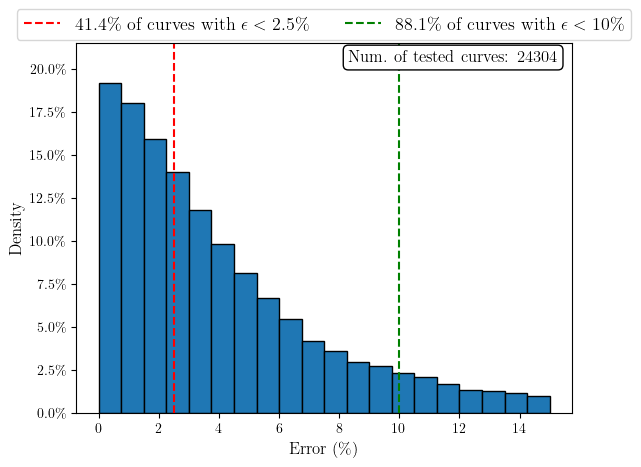

<Figure size 640x480 with 0 Axes>

{'model_name': 'Regression_Hertz', 'model_loss': 0.006658060476183891, 'model_error': 4.701819541831659, 'under_1%_error': 0.18490783410138248, 'under_2.5%_error': 0.4144585253456221, 'under_5%_error': 0.6733459512837393, 'under_10%_error': 0.8807603686635944, 'total_curves': 24304}


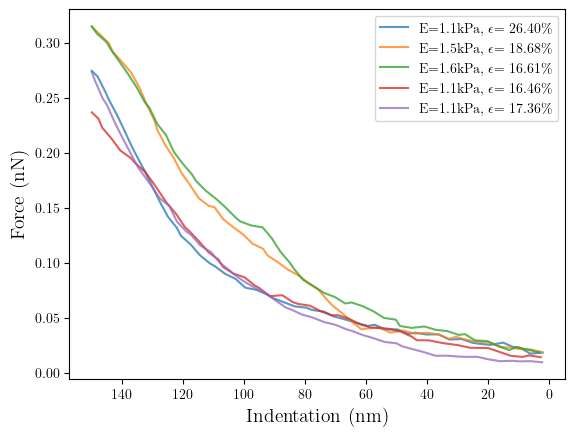

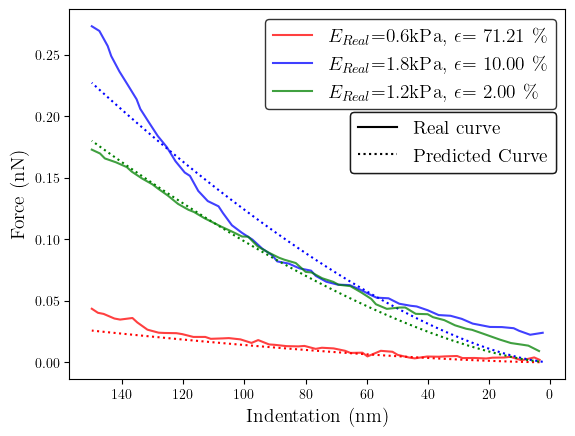

In [47]:
eval_model(loaded_model, test_exp_loader, loss_fn, error_fn, parent_dir, model_dir)

# Predict the Young's Modulus from surface maps
1. Only the original height distribution is known
2. Height distribution will ve related linearly with a predefined range of E-values
3. A synthetic map of 'real values is then created'
4. This map is downsized from (N, N) to (n, n)
5. n x n curves are chosen from experimental dataset, based on their E values (for each E in the map, the curve in the experimental dataset with the closest E is chosen)
6. Each curve goes as an input to our model and a final map with the error contour is plotted (E_matrix_map -> input_vector -> output_vector -> E_matrix_map_pred)


In [59]:
parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface'
# parent_dir = os.getcwd()

# directory with .mat files
surf_map_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\mySurfGenApp' 
os.chdir(surf_map_dir)
mat_file_name = 'gauss_rough_1.mat'
target_file = h5py.File(mat_file_name, 'r')
os.chdir(parent_dir)

In [60]:
surf_variables = list(target_file.keys())
surf_variables

# Define E range
surf_E_min = 1.5
surf_E_max = 5.0

In [61]:
# Reduce initial map size
def transform_matrix(mat):
    orig_size = mat.shape[0]
    target_size = 32
    ratio = orig_size//target_size
    mat = np.array(mat)
    mat = mat[::ratio, ::ratio] # ::step
    return mat
a = np.arange(0, 256**2, 1).reshape((256,256))
a.shape, transform_matrix(a).shape

((256, 256), (32, 32))

In [62]:
X_full = target_file['X'][()]
Y_full = target_file['Y'][()]
Z_full = target_file['Z'][()]

X = transform_matrix(X_full)
Y = transform_matrix(Y_full)
Z = transform_matrix(Z_full)
X.shape, Y.shape, Z.shape, Z.size

# Get E_pred and error arrays, from 'Test_Experimental' folder
# We'll stay in this directory until the final function is called
os.chdir(model_dir)
os.chdir('Test_Experimental_90_final')
E_pred_array = np.load('predicts_list.npy')
error_array = np.load('error_list.npy')

In [63]:
# Normalize Z to [0, 1]
Z_norm = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

# Z -> E matrix normalized
E_mat_norm = Z_norm * (surf_E_max-surf_E_min) + surf_E_min

df_final.head()

,ehertz,ind_pos,force_pos,ind,force
0,0.694769,"[0.3677106956040672, 2.3894120022318335, 4.204...","[0.007094921204119162, 0.006684687665400049, 0...","[2.3894120022318335, 4.204716175965981, 7.8926...","[0.006684687665400049, 0.00833842545561826, 0...."
1,0.823905,"[1.4537165814971136, 3.6562397575275614, 5.400...","[0.00918162128946639, 0.007003182428568775, 0....","[3.6562397575275614, 5.400102638238673, 9.0655...","[0.007003182428568775, 0.009411346520865657, 0..."
2,1.079908,"[0.3506678225925153, 2.156678333828264, 4.0200...","[0.01631872563162927, 0.018145407080535317, 0....","[2.156678333828264, 6.227329074266268, 9.66732...","[0.018145407080535317, 0.01721247279868348, 0...."
3,0.904791,"[1.7828272566139542, 3.7908524937066512, 5.443...","[0.013279228894842579, 0.013047766464743664, 0...","[3.7908524937066512, 7.640638610838751, 9.3849...","[0.013047766464743664, 0.014247485175078779, 0..."
4,0.778961,"[0.5590719990182703, 2.6838756792040472, 4.504...","[0.006923747199317079, 0.005523131995092312, 0...","[2.6838756792040472, 4.504816913740738, 8.4161...","[0.005523131995092312, 0.007161141247358401, 0..."


In [64]:
idx_array = np.array(df_final.index.tolist())
E_exp_array = np.array(df_final['ehertz'].tolist())

E_map = np.zeros(Z.shape)
E_pred_map = np.zeros(Z.shape)
error_map = np.zeros(Z.shape)
idx_map = np.zeros(Z.shape)
x_map = np.zeros((Z.shape[1], Z.shape[0], 2, npts))

# Create matrices with map properties
for i in range(E_map.shape[0]):
    for j in range(E_map.shape[1]):
        diff = abs(E_exp_array - E_mat_norm[i][j])
        aux_idx = np.argmin(diff)
        E_map[i][j] = E_exp_array[aux_idx]
        idx_map[i][j] = idx_array[aux_idx]
        E_pred_map[i][j] = E_pred_array[aux_idx]
        error_map[i][j] = error_array[aux_idx]
        x_map[i][j][0] = np.array(df_final.loc[idx_array[aux_idx], 'ind'])
        x_map[i][j][1] = np.array(df_final.loc[idx_array[aux_idx], 'force'])
        E_exp_array = np.delete(E_exp_array, aux_idx)
        idx_array = np.delete(idx_array, aux_idx)
        E_pred_array = np.delete(E_pred_array, aux_idx)
        error_array = np.delete(error_array, aux_idx)


In [65]:
# Check if there are no repeated values in the E_matrix
unique_elements = np.unique(E_map)
if len(unique_elements) == E_map.size:
    print("Great success!!!")
else:
    print("There are repeated values.")
len(unique_elements), E_map.size       

Great success!!!


(1024, 1024)

In [66]:
# Check if each value in each matrix is correctly related with the values at the same position in other matrices
count = 0
for i in range(E_map.shape[0]):
    for j in range(E_map.shape[1]):
        count+=1 
        aux_idx = idx_map[i][j]
        if df_final.loc[aux_idx, 'ehertz'] != E_map[i][j] and df_final.loc[aux_idx, 'ind'] != x_map[i][j][0] and df_final.loc[aux_idx, 'force'] != x_map[i][j][1]:
            print(f"Something wrong in position: ({i},{j})")
if count == E_map.size:
    print('Great success!!!')

Great success!!!


In [67]:
# plot_Emap(X, Y, Z, E_map, E_pred_map, 2.04567, 4)
# plot_error_map(X, Y, Z, error_map)
a, b, c = get_min_max_error(error_map)
X[a], Y[a], Z[a], X[b], Y[b], Z[b], X[c], Y[c], Z[c], c


(array([0.84705882]),
 array([0.03137255]),
 array([0.54725859]),
 array([0.94117647]),
 array([0.37647059]),
 array([-0.65443367]),
 array([0.18823529]),
 array([0.87843137]),
 array([0.25075809]),
 (array([6], dtype=int64), array([28], dtype=int64)))

In [68]:
def analyse_map(mat_file_name, 
                surf_E_min, surf_E_max, 
                X, Y, Z, E_map, E_pred_map, error_map, idx_map, x_map, X_full, Y_full, Z_full,
                parent_dir):
    # Function to analyse the map results
    new_dir = mat_file_name[:-4] + '_' + str(int(surf_E_min*10)) + '__' + str(int(surf_E_max*10))
    os.mkdir(new_dir)
    os.chdir(new_dir)
    # Save the matrices
    var_list = [X, Y, Z, E_map, E_pred_map, error_map, idx_map, x_map]
    create_npy(var_list)
    # Get error statistics related to the surface
    error = np.average(error_map)
    error2_5 = np.count_nonzero(error_map<2.5)/error_map.size
    error5 = np.count_nonzero(error_map<5)/error_map.size
    error10 = np.count_nonzero(error_map<10)/error_map.size
    results_dict = {"model_error": error,
                    "under_2.5%_error": error2_5,
                    "under_5%_error": error5,
                    "under_10%_error": error10,
                    "total_curves": error_map.size}    
    with open('test_results.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict.keys())
        writer.writeheader()
        writer.writerow(results_dict)
    # Create the plots
    plot_Emap(X, Y, Z, E_map, E_pred_map, surf_E_min, surf_E_max)
    plot_error_map(X, Y, Z, error_map)
    plot_error_hist(error_map.flatten(), test=True, error1=error2_5, error2=error10)
    plot_map(X, Y, Z, error_map, X_full, Y_full, Z_full)
    plot_org_map(X_full, Y_full, Z_full)
    plot_pred_real_curves2(error_map, x_map, E_map, E_pred_map, nu, r)  
    # Return to the parent directory    
    os.chdir(parent_dir)

C:\Users\luisr\AppData\Local\Temp\ipykernel_22704\2570211005.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable, shrink=0.6, aspect=10)
C:\Users\luisr\AppData\Local\Temp\ipykernel_22704\2570211005.py:113: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable, shrink=0.6, aspect=10)


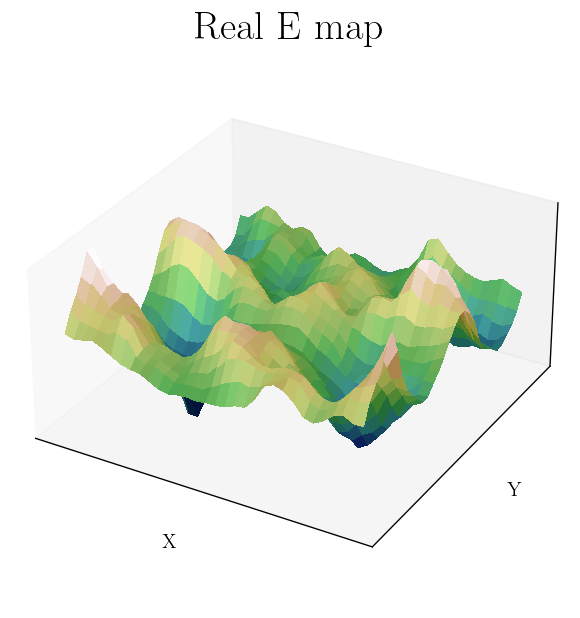

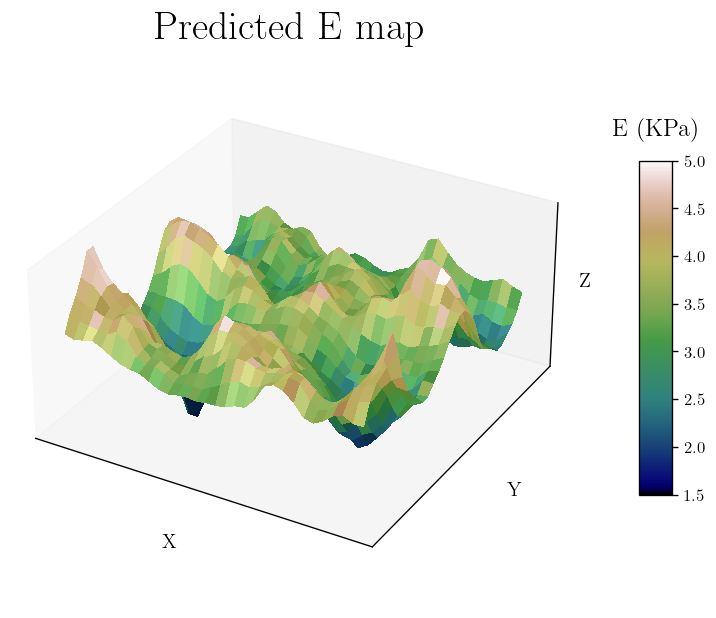

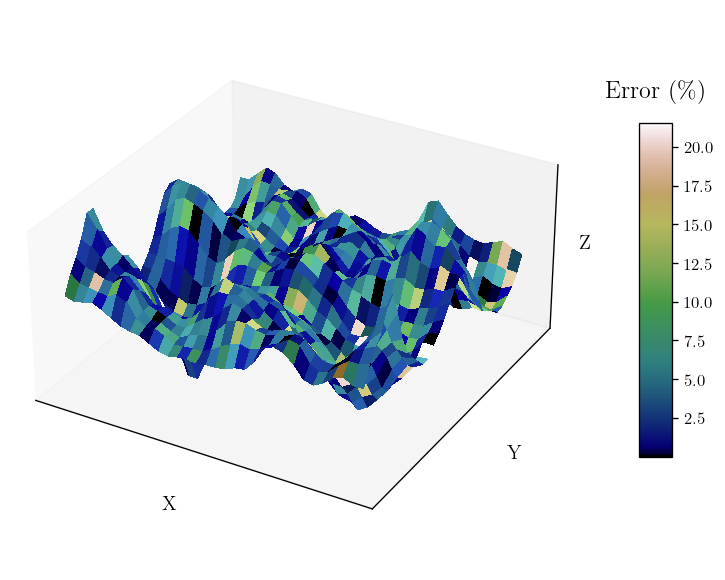

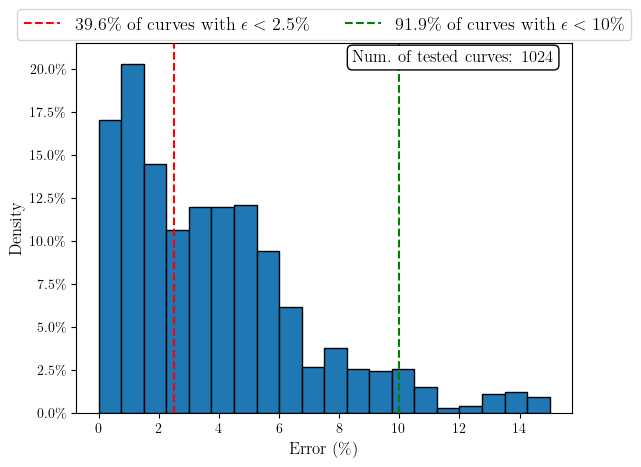

<Figure size 640x480 with 0 Axes>

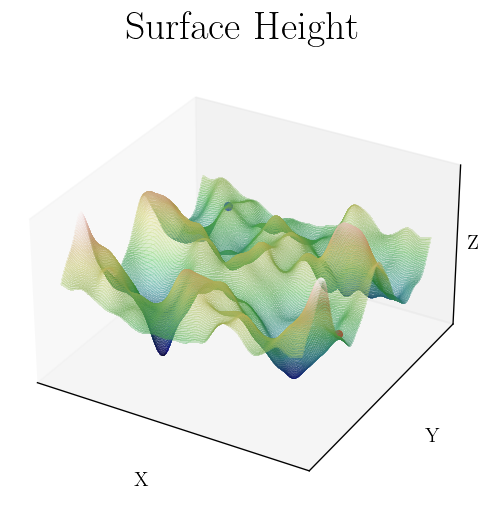

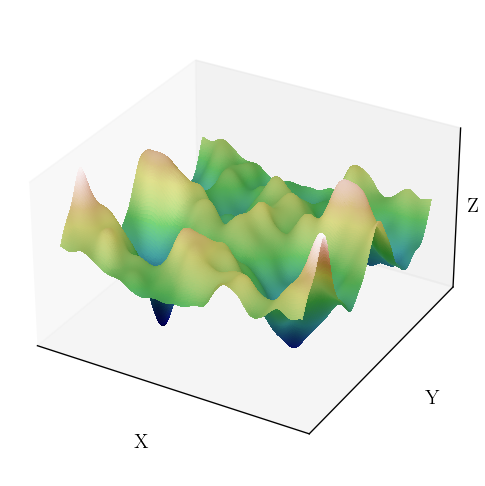

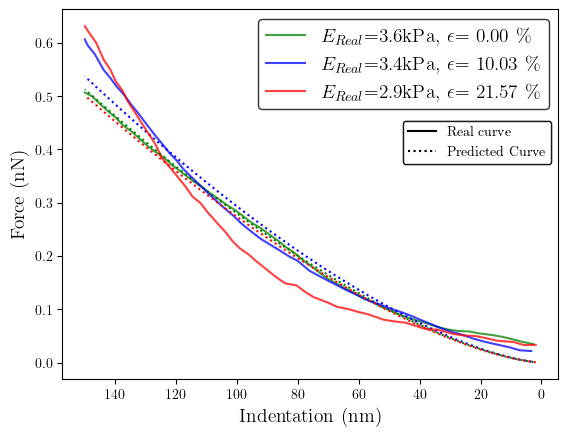

In [69]:
analyse_map(mat_file_name, surf_E_min, surf_E_max, X, Y, Z, E_map, E_pred_map, error_map, idx_map, x_map, X_full, Y_full, Z_full, parent_dir)